In [1]:
from NetGEN.generation import CRNGen

# Path to data
datapath = "../../FluentData/ULBFurnace"

# Import the data creating a dictionary
datainfo = {}
datainfo["volume"] = "data_volumes"         # Cells volume (m3) MANDATORY
datainfo["angle"] = "data_angle"            # Velocity angle
datainfo["solution"] = "data_solution"      # Thermo-chemical solution MANDATORY
datainfo["density"] = "data_density"        # Density (kg/m3) 
datainfo["velocity"] = "data_velocity"      # Velocity magnitude
datainfo["tau"] = "data_tau"                # Residence time
datainfo["Tvar"] = "data_Trms"              # Temperature variance (K)

# Initialize the generator object
crngen = CRNGen()

In [2]:
# -------------- Preliminary steps ------------- #

# 1) Set the data dictionary
crngen.setDataDictionary(datainfo, datapath, 2)

# 2) Set the reference mesh graph for graph reassignemt
connfile = datapath + "/Neighbours_cell_flows"
crngen.setGraph(filepath=connfile, option='fluent')

# 3) Set the data to be used for clustering (default option "state-space")
crngen.setData(dataset = 'state-space')

Cluster  0  is disconnected in  2  components
Cluster  3  is disconnected in  2  components
Cluster  5  is disconnected in  4  components
Cluster  15  is disconnected in  2  components
Cluster  19  is disconnected in  2  components
There are  7  unconnected components in total
Reassigning component of subgraph of cluster  0
Component was reassigned to cluster  19
Reassigning component of subgraph of cluster  3
Component was reassigned to cluster  7
Reassigning component of subgraph of cluster  5
Component was reassigned to cluster  24
Cluster with only one cell found
Cluster with only one cell found
A new cluster has been created
Reassigning component of subgraph of cluster  19
Component was reassigned to cluster  17
Convergence reached, the clusters are now connected
Number of clusters greater than desired number of clusters, agglomeration is needed
No clusters removed
--- Reactor matching code iteration  0  ---
There are  0  unconnected components in total
Actual number of clusters =

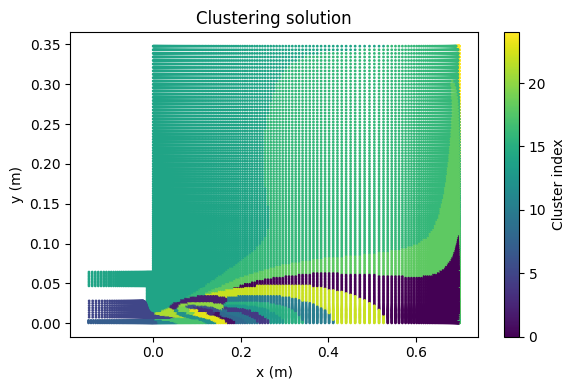

In [3]:
# -------------- Clustering steps ------------- #

# Select the number of clusters
k = 25

# Run the unsupervised + graph reassignment clustering for CRN generation
crngen.RunClustering(k, graph_reassign=True, reassign_method='volume', v_thresh=0.001, scaling='auto', verbose=True)

# Plot the clustering results on a scatter plot
crngen.plotClusters()

In [ ]:
# -------------- Build and run CRN ------------- #

# Import cantera
import cantera as ct

# Select kinetic mechanism
cmech = "gri30.yaml"

# Fuel
g1 = ct.Solution("gri30.yaml")
g1.TPX = 300.0, 101325.0, "CH4:0.5, H2:0.5"

# Air
g2 = ct.Solution("gri30.yaml")
g2.TPX = 872.0, 101325.0, "O2:0.21, N2:0.79"

# Create the dictionary of the streams
fuel = {}
fuel['fluentid'] = 35
fuel['id'] = 0
fuel['name'] = 'fuel'
fuel['gas'] = g1

air = {}
air['fluentid'] = 15
air['id'] = 1
air['name'] = 'air'
air['gas'] = g2

# Streams must be a list of dictionaries. Each dictionary MUST contain:
# 'fluentid': id of the inlet in Fluent (if Fluent interface is used)
# 'id': must be ordered from 0 to number of inlet streams
# 'gas': reference Cantera solution (or Quantity) object identifying state
# 'name': custom name for the stream
streams = [fuel, air]

# Get mass flowrates
crngen.getMassFlowrates()

#  Read boundary cells file to get inlet streams
filepath = datapath + "/Boundary_cells"
crngen.getInletStreams(streams, filepath, verbose=True)

# Get attributes of the reactors
kincorr = True  # flag for using kinetic corrections
crngen.getReactorAttributes(kincorr=True)

# Check mass balance of the network
crngen.checkMassBalance(tol=1e-4, verbose=True)

# Set path to chemmkin-type kinetic mechanisms
kinfile     = "/Users/matteosavarese/Desktop/Dottorato/Kinetics/GRI3.0/gri30.CKI"
thermofile  = "/Users/matteosavarese/Desktop/Dottorato/Kinetics/GRI3.0/thermo.dat"
canteramech = 'gri30.cti' 

# Path to NetSMOKEpp.sh
netsmoke_path = "/Users/matteosavarese/Desktop/Dottorato/Github/NetSMOKEpp/SeReNetSMOKEpp-master/projects/Linux"
crn, crngen = crngen.setNetsmokeCRN(kinfile, thermofile, canteramech, netsmoke_path, verbose=True)
crn.RunSimulation(netsmoke_path)

In [ ]:
# -------------- Post-process Network ------------- #
outputs = crn.ExtractOutputs()

for i in range(len(outputs)):
    ri = outputs[i]
    NO = outputs[i].X[g1.species_index('NO')]
    print(f"NO in Reactor {i} = {NO*1e6} ppm")